# Pharyngeal endoderm development analysis with RealTimeKernel

## Import packages

In [1]:
import os
import sys

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import cellrank as cr
import scanpy as sc
import scvelo as scv
import wot

from cr2 import get_state_purity, plot_state_purity, plot_states, running_in_notebook

sys.path.extend(["../../../", "."])
from paths import DATA_DIR, FIG_DIR  # isort: skip  # noqa: E402

Global seed set to 0


## General settings

In [2]:
sc.settings.verbosity = 2
cr.settings.verbosity = 4
scv.settings.verbosity = 3

In [3]:
scv.settings.set_figure_params("scvelo", dpi_save=400, dpi=80, transparent=True, fontsize=20, color_map="viridis")

In [4]:
SAVE_FIGURES = False
if SAVE_FIGURES:
    os.makedirs(FIG_DIR / "realtime_kernel" / "pharyngeal_endoderm", exist_ok=True)

SHOW_COLORBAR = not SAVE_FIGURES

In [5]:
(DATA_DIR / "pharyngeal_endoderm" / "results").mkdir(parents=True, exist_ok=True)

## Constants

In [6]:
# fmt: off
S_GENES = [
    "Mcm5", "Pcna", "Tyms", "Fen1", "Mcm2", "Mcm4", "Rrm1", "Ung", "Gins2",
    "Mcm6", "Cdca7", "Dtl", "Prim1", "Uhrf1", "Mlf1ip", "Hells", "Rfc2",
    "Rpa2", "Nasp", "Rad51ap1", "Gmnn", "Wdr76", "Slbp", "Ccne2", "Ubr7",
    "Pold3", "Msh2", "Atad2", "Rad51", "Rrm2", "Cdc45", "Cdc6", "Exo1",
    "Tipin", "Dscc1", "Blm", "Casp8ap2", "Usp1", "Clspn", "Pola1", "Chaf1b",
    "Brip1", "E2f8",
]

G2M_GENES = [
    "Hmgb2", "Cdk1", "Nusap1", "Ube2c", "Birc5", "Tpx2", "Top2a", "Ndc80",
    "Cks2", "Nuf2", "Cks1b", "Mki67", "Tmpo", "Cenpf", "Tacc3", "Fam64a",
    "Smc4", "Ccnb2", "Ckap2l", "Ckap2", "Aurkb", "Bub1", "Kif11", "Anp32e",
    "Tubb4b", "Gtse1", "Kif20b", "Hjurp", "Cdca3", "Hn1", "Cdc20", "Ttk",
    "Cdc25c", "Kif2c", "Rangap1", "Ncapd2", "Dlgap5", "Cdca2", "Cdca8",
    "Ect2", "Kif23", "Hmmr", "Aurka", "Psrc1", "Anln", "Lbr", "Ckap5",
    "Cenpe", "Ctcf", "Nek2", "G2e3", "Gas2l3", "Cbx5", "Cenpa",
]
# fmt: on

## Data loading

In [7]:
adata = sc.read(DATA_DIR / "pharyngeal_endoderm" / "raw" / "adata_pharynx.h5ad")
adata.obsm["X_umap"] = adata.obs[["UMAP1", "UMAP2"]].values
adata.obs["day"] = adata.obs["day_str"].astype(float)
adata.obs = adata.obs[["cluster_name", "day", "is_doublet"]]

adata.obs["cluster_fine"] = (
    pd.read_csv(DATA_DIR / "pharyngeal_endoderm" / "raw" / "cluster_data.csv", index_col=0)
    .loc[adata.obs_names, "res.1"]
    .values
)
adata.obs["cluster_fine"] = adata.obs["cluster_fine"].astype(str).astype("category")

adata = adata[adata.obs["cluster_fine"].isin(["2", "4", "9", "12", "25", "26"]), :].copy()
adata.uns["cluster_name_colors"] = ["#023fa5", "#bec1d4", "#b5bbe3", "#e07b91", "#11c638"]

adata

AnnData object with n_obs × n_vars = 11073 × 27998
    obs: 'cluster_name', 'day', 'is_doublet', 'cluster_fine'
    uns: 'cluster_name_colors'
    obsm: 'X_umap'

In [8]:
mouse_tfs = (
    pd.read_csv(DATA_DIR / "generic" / "mouse_tfs.tsv", sep="\t", header=None)
    .rename(columns={0: "Ensemble ID", 1: "Gene ID"})["Gene ID"]
    .tolist()
)

## Data preprocessing

In [9]:
sc.pp.highly_variable_genes(adata)

extracting highly variable genes
    finished (0:00:03)


In [10]:
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=30)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished (0:02:27)


In [11]:
sc.tl.umap(adata)

computing UMAP
    finished (0:00:06)


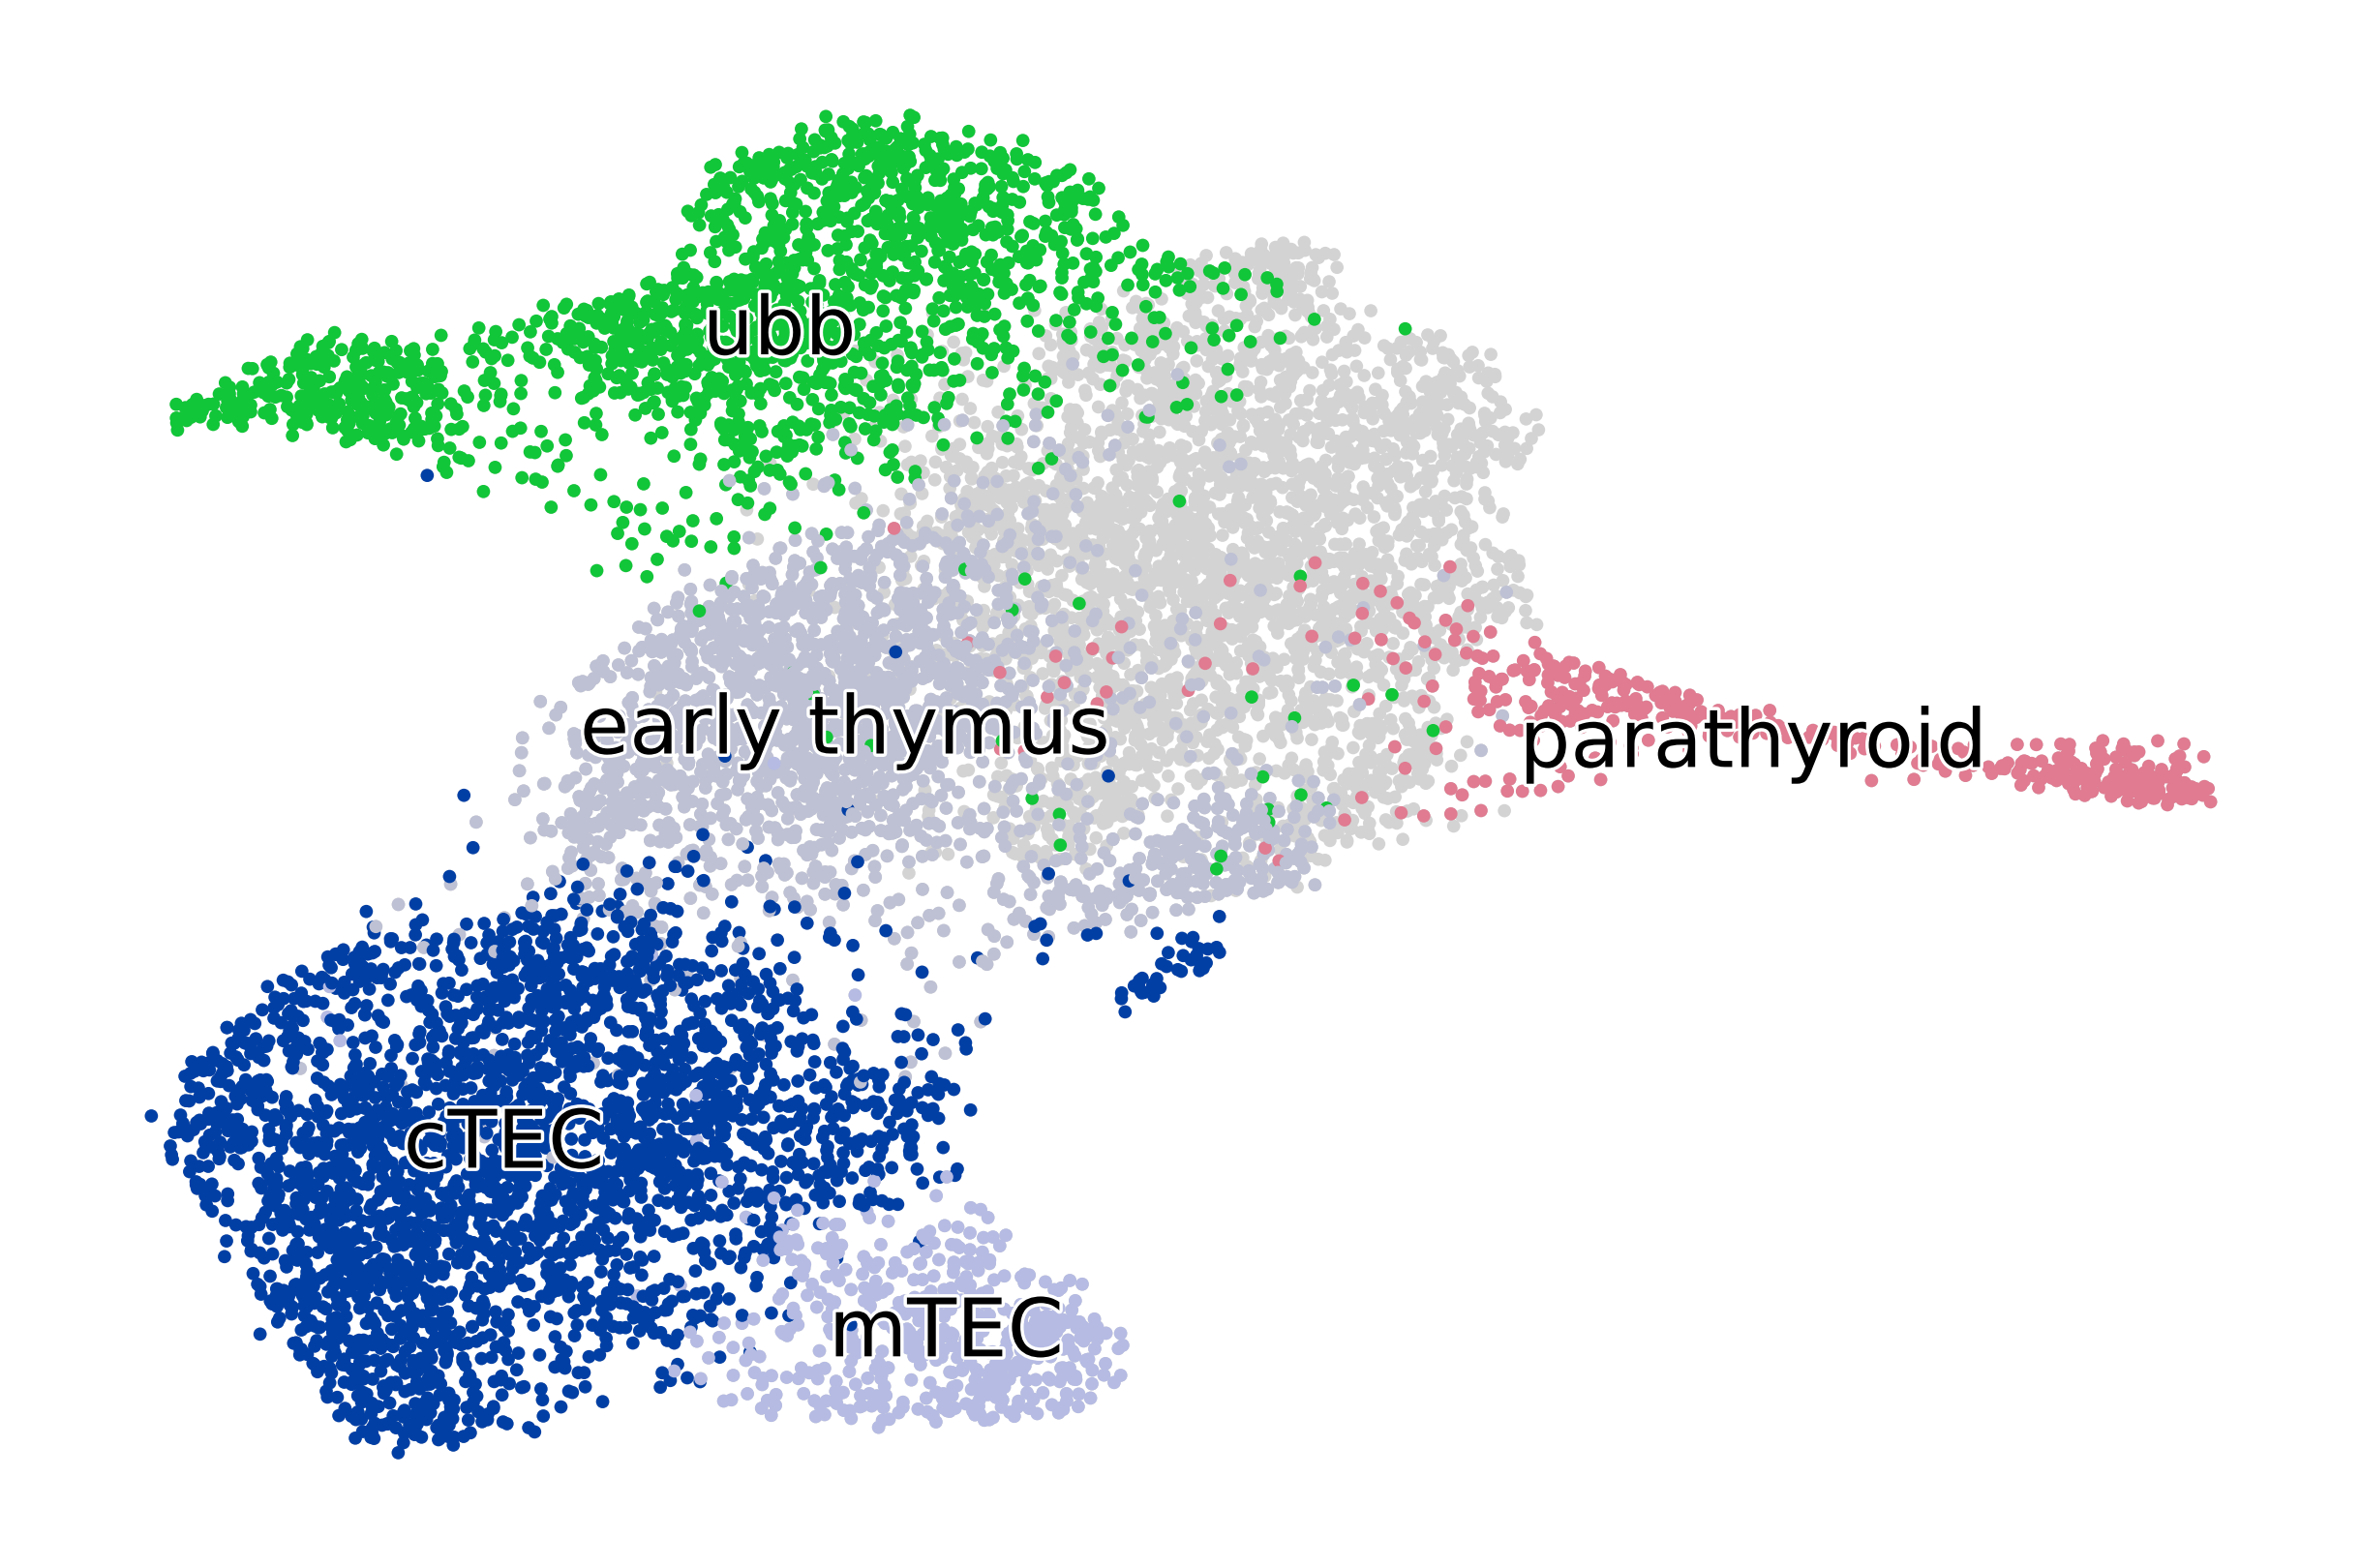

In [12]:
if running_in_notebook():
    scv.pl.scatter(
        adata, basis="umap", c="cluster_name", title="", dpi=250, legend_fontsize=12, legend_fontweight="normal"
    )

if SAVE_FIGURES:
    fig, ax = plt.subplots(figsize=(6, 4))
    scv.pl.scatter(adata, basis="umap", c="cluster_name", legend_loc=False, title="", ax=ax)
    fig.savefig(
        FIG_DIR / "realtime_kernel" / "pharyngeal_endoderm" / "umap_colored_by_cell_type_subsetted_data.eps",
        format="eps",
        transparent=True,
        bbox_inches="tight",
    )

    fig, ax = plt.subplots(figsize=(6, 4))
    scv.pl.scatter(adata, basis="umap", c="day", legend_loc=False, colorbar=SHOW_COLORBAR, title="", ax=ax)
    fig.savefig(
        FIG_DIR / "realtime_kernel" / "pharyngeal_endoderm" / "umap_colored_by_day_subsetted_data.eps",
        format="eps",
        transparent=True,
        bbox_inches="tight",
    )

## RealTimeKernel analysis

In [13]:
if not (DATA_DIR / "pharyngeal_endoderm" / "tmaps_subsetted_data").exists():
    ot_model = wot.ot.OTModel(adata)
    ot_model.compute_all_transport_maps(tmap_out=DATA_DIR / "pharyngeal_endoderm" / "tmaps_subsetted_data" / "tmaps")

In [14]:
adata.obs["day"] = adata.obs["day"].astype("category")

rtk = cr.kernels.RealTimeKernel.from_wot(
    adata, path=DATA_DIR / "pharyngeal_endoderm" / "tmaps_subsetted_data", time_key="day"
)
rtk.compute_transition_matrix(
    growth_iters=3, growth_rate_key="growth_rate_init", self_transitions="all", conn_weight=0.1
)

Only considering the two last: ['.5', '.h5ad'].
Only considering the two last: ['.5', '.h5ad'].
Only considering the two last: ['.5', '.h5ad'].
Only considering the two last: ['.5', '.h5ad'].
Only considering the two last: ['.5', '.h5ad'].
Only considering the two last: ['.5', '.h5ad'].


  0%|          | 0/3 [00:00<?, ?time pair/s]

Using automatic `threshold=0.002242638496682048`
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:00)


RealTimeKernel[n=11073, growth_iters=3, growth_rate_key='growth_rate_init', threshold='auto', self_transitions='all']

### Estimator

Computing Schur decomposition
Adding `adata.uns['eigendecomposition_fwd']`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:00)


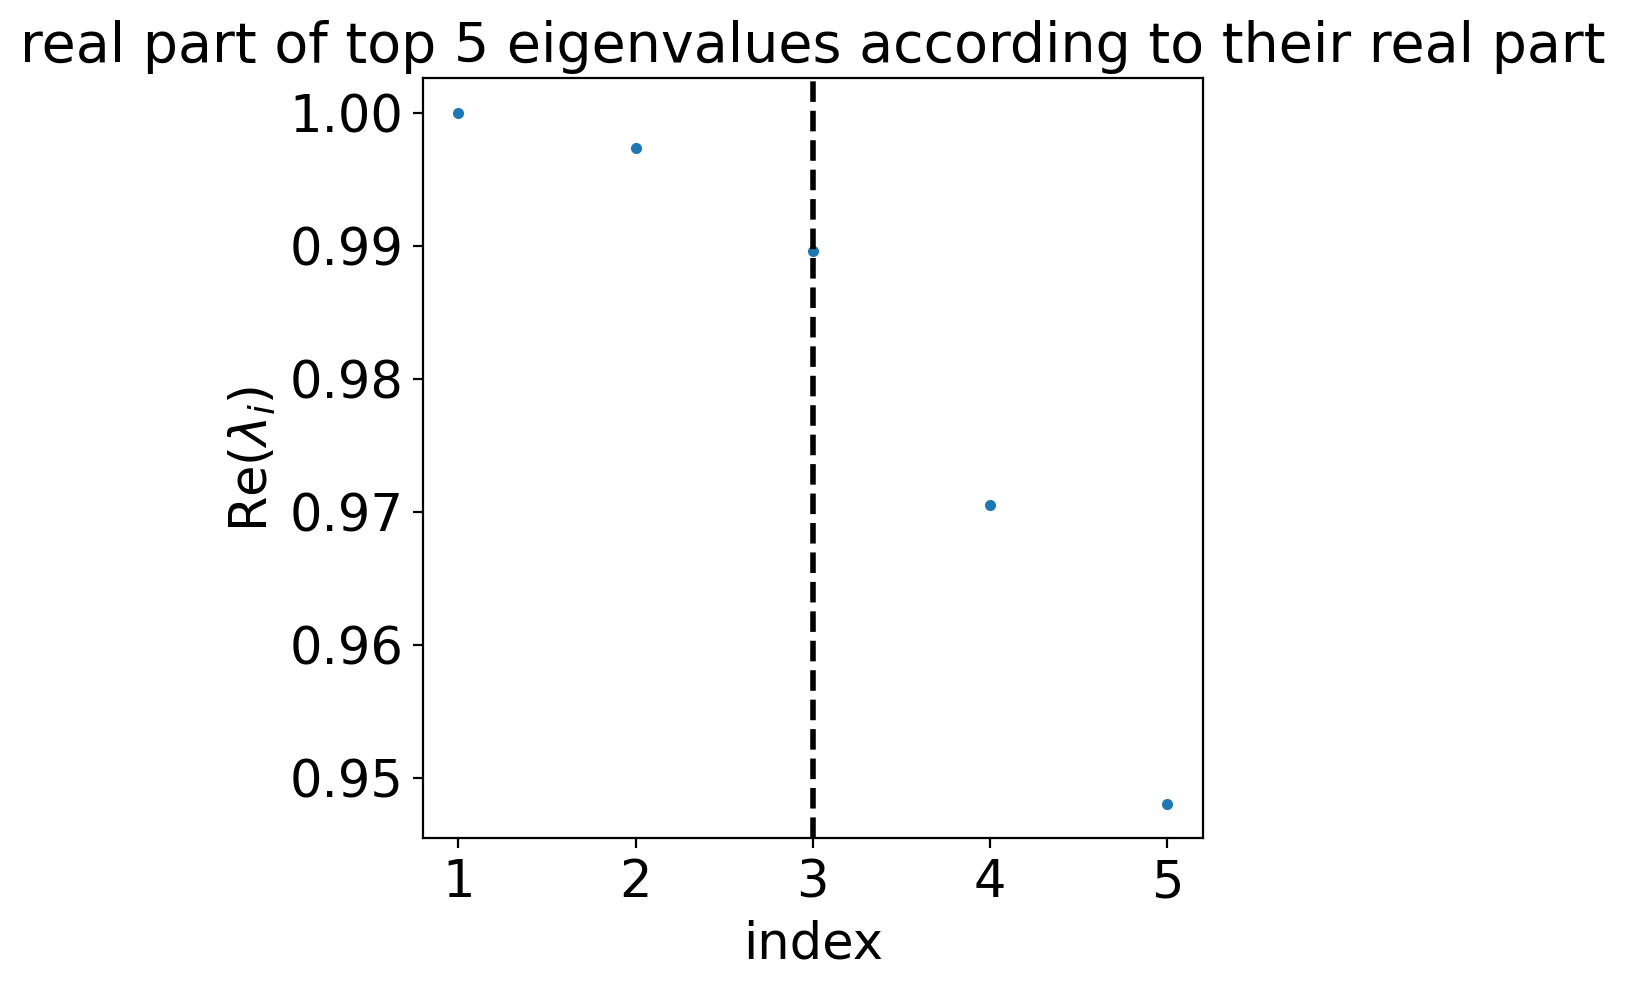

In [15]:
estimator = cr.estimators.GPCCA(rtk)
estimator.compute_schur(n_components=5)
estimator.plot_spectrum(real_only=True)
plt.show()

Computing `4` macrostates
DEBUG: Setting the macrostates using macrostates memberships
DEBUG: Raising an exception if there are less than `6` cells.
Adding `.macrostates`
       `.macrostates_memberships`
       `.coarse_T`
       `.coarse_initial_distribution
       `.coarse_stationary_distribution`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:00)


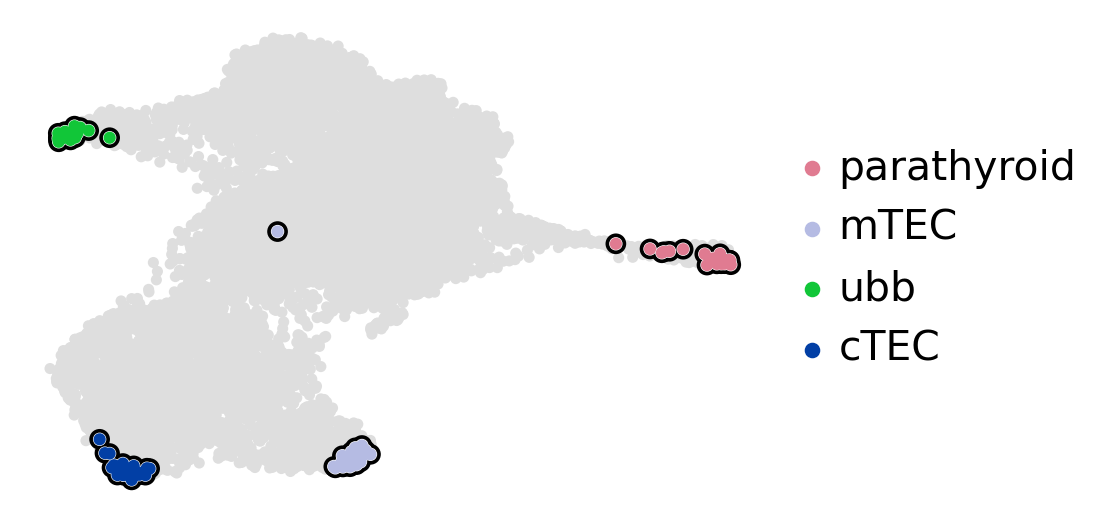

In [16]:
estimator.compute_macrostates(n_states=4, cluster_key="cluster_name")

if running_in_notebook():
    plot_states(
        adata,
        estimator=estimator,
        which="macrostates",
        basis="umap",
        legend_loc="right",
        title="",
        size=100,
    )

if SAVE_FIGURES:
    fpath = FIG_DIR / "realtime_kernel" / "pharyngeal_endoderm" / "umap_colored_by_macrostates_subsetted_data.pdf"
    plot_states(
        adata,
        estimator=estimator,
        which="macrostates",
        basis="umap",
        legend_loc=False,
        title="",
        size=100,
        fpath=fpath,
        format="pdf",
    )

Mean purity: 0.9916666666666667


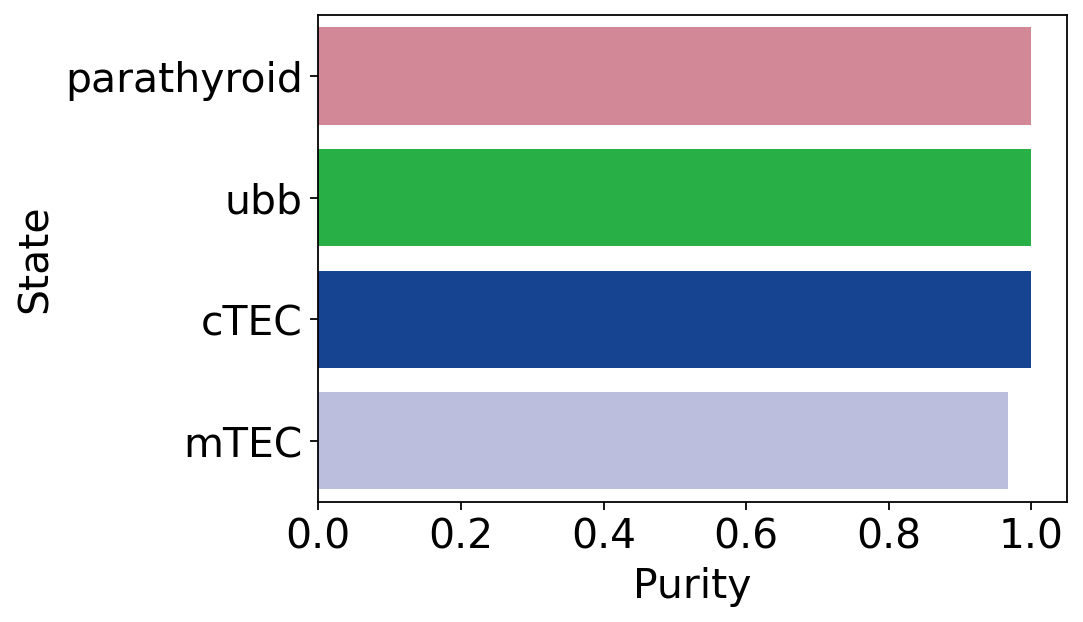

In [17]:
macrostate_purity = get_state_purity(adata, estimator, states="macrostates", obs_col="cluster_name")
print(f"Mean purity: {np.mean(list(macrostate_purity.values()))}")

if running_in_notebook():
    if SAVE_FIGURES:
        fpath = FIG_DIR / "realtime_kernel" / "pharyngeal_endoderm" / "macrostate_purity_subsetted_data.eps"
    else:
        fpath = None

    palette = dict(zip(estimator.macrostates.cat.categories, estimator._macrostates.colors))

    plot_state_purity(macrostate_purity, palette=palette, fpath=fpath, format="eps")
    plt.show()

DEBUG: Raising an exception if there are less than `6` cells.
Adding `adata.obs['term_states_fwd']`
       `adata.obs['term_states_fwd_probs']`
       `.terminal_states`
       `.terminal_states_probabilities`
       `.terminal_states_memberships
    Finish`


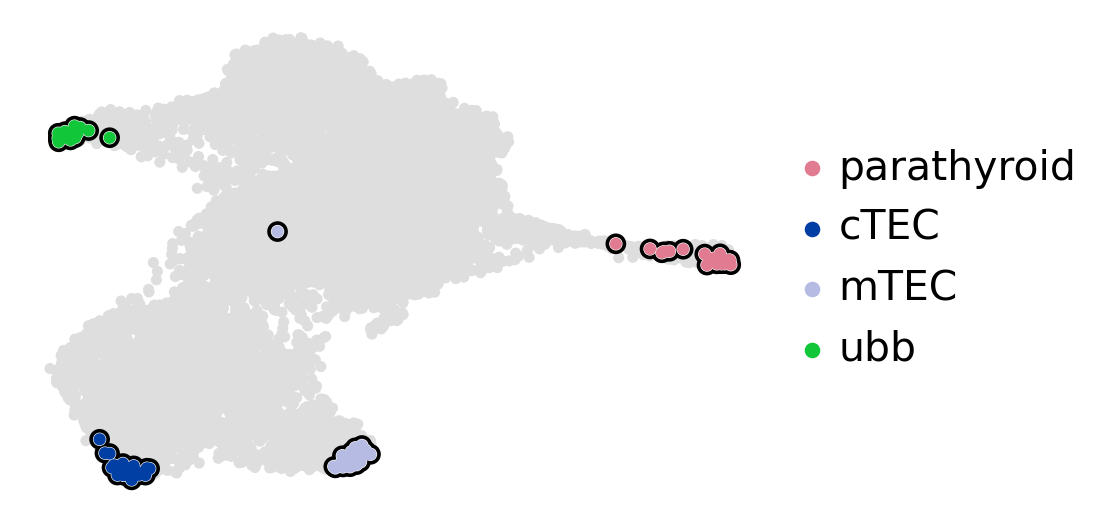

In [18]:
estimator.set_terminal_states(["parathyroid", "cTEC", "mTEC", "ubb"])

if running_in_notebook():
    plot_states(
        adata,
        estimator=estimator,
        which="terminal_states",
        basis="umap",
        legend_loc="right",
        title="",
        size=100,
        fpath=fpath,
    )

if SAVE_FIGURES:
    fpath = FIG_DIR / "realtime_kernel" / "pharyngeal_endoderm" / "umap_colored_by_terminal_states_subsetted_data.pdf"
    plot_states(
        adata,
        estimator=estimator,
        which="terminal_states",
        basis="umap",
        legend_loc=False,
        title="",
        size=100,
        fpath=fpath,
        format="pdf",
    )

Mean purity: 0.9916666666666667


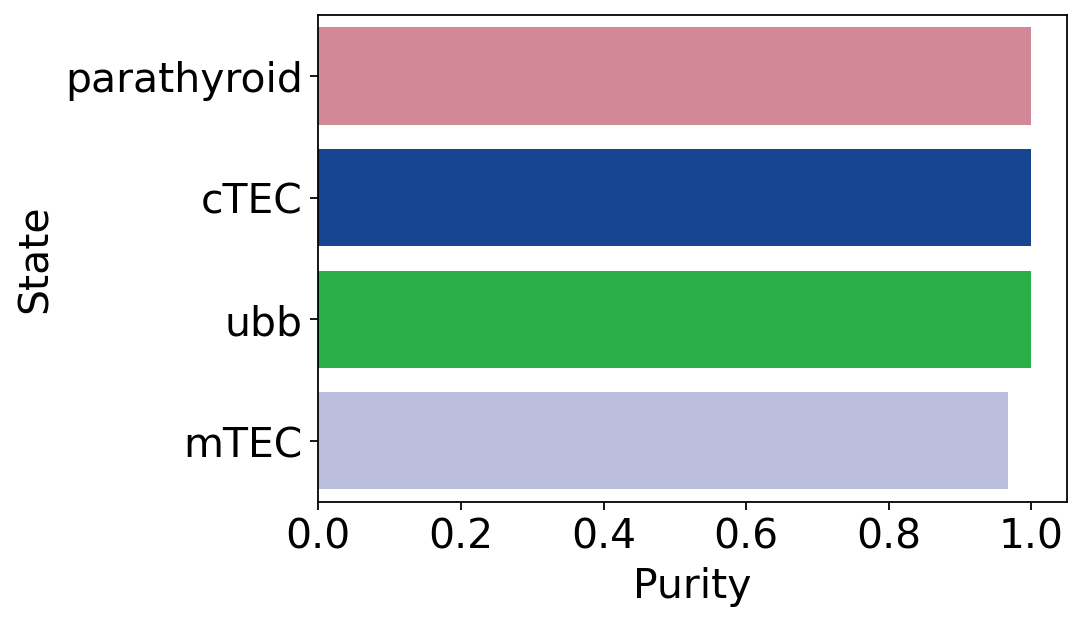

In [19]:
macrostate_purity = get_state_purity(adata, estimator, states="terminal_states", obs_col="cluster_name")
print(f"Mean purity: {np.mean(list(macrostate_purity.values()))}")

if running_in_notebook():
    if SAVE_FIGURES:
        fpath = FIG_DIR / "realtime_kernel" / "pharyngeal_endoderm" / "terminal_states_purity_subsetted_data.eps"
    else:
        fpath = None

    palette = dict(zip(estimator.terminal_states.cat.categories, estimator._term_states.colors))

    plot_state_purity(macrostate_purity, palette=palette, fpath=fpath, format="eps")
    plt.show()

In [20]:
estimator.compute_fate_probabilities(solver="gmres", use_petsc=True)

Computing fate probabilities
DEBUG: Solving the linear system using `PETSc` solver `'gmres'` on `1` core(s) with no preconditioner and `tol=1e-06`


  0%|          | 0/4 [00:00<?, ?/s]

Adding `adata.obsm['lineages_fwd']`
       `.fate_probabilities`
    Finish (0:00:00)


[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


Computing fate probabilities
DEBUG: Solving the linear system using `PETSc` solver `'gmres'` on `1` core(s) with no preconditioner and `tol=1e-06`


  0%|          | 0/4 [00:00<?, ?/s]

Adding `adata.obsm['lineages_fwd']`
       `.fate_probabilities`
    Finish (0:00:00)


[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket


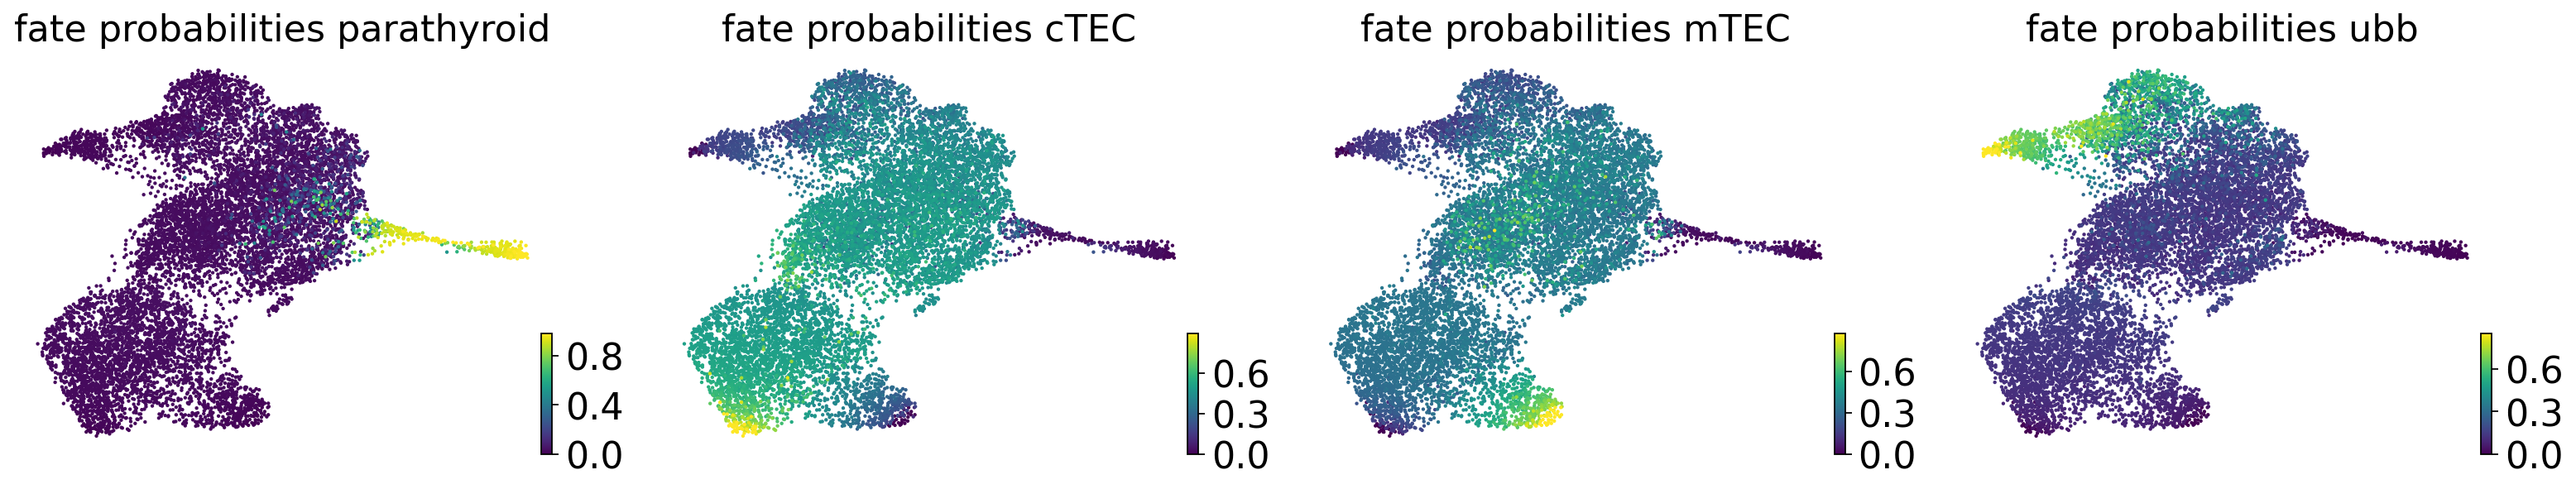

In [21]:
estimator.compute_fate_probabilities()
if running_in_notebook():
    estimator.plot_fate_probabilities(same_plot=False, basis="umap", ncols=4)

if SAVE_FIGURES:
    for terminal_state in estimator.terminal_states.cat.categories:
        adata.obs[f"fate_prob_{terminal_state}"] = adata.obsm["lineages_fwd"][:, terminal_state].X.squeeze()
        fig, ax = plt.subplots(figsize=(6, 4))

        if running_in_notebook():
            scv.pl.scatter(
                adata,
                basis="umap",
                color=f"fate_prob_{terminal_state}",
                cmap="viridis",
                title="",
                colorbar=SHOW_COLORBAR,
                ax=ax,
            )

            fig.savefig(
                FIG_DIR / "realtime_kernel" / "pharyngeal_endoderm" / f"fate_prob_{terminal_state}_subsetted_data.eps",
                format="eps",
                transparent=True,
                bbox_inches="tight",
            )

Computing fate probabilities
DEBUG: Solving the linear system using `PETSc` solver `'gmres'` on `1` core(s) with no preconditioner and `tol=1e-06`


  0%|          | 0/4 [00:00<?, ?/s]

Adding `adata.obsm['lineages_fwd']`
       `.fate_probabilities`
    Finish (0:00:00)


[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: 

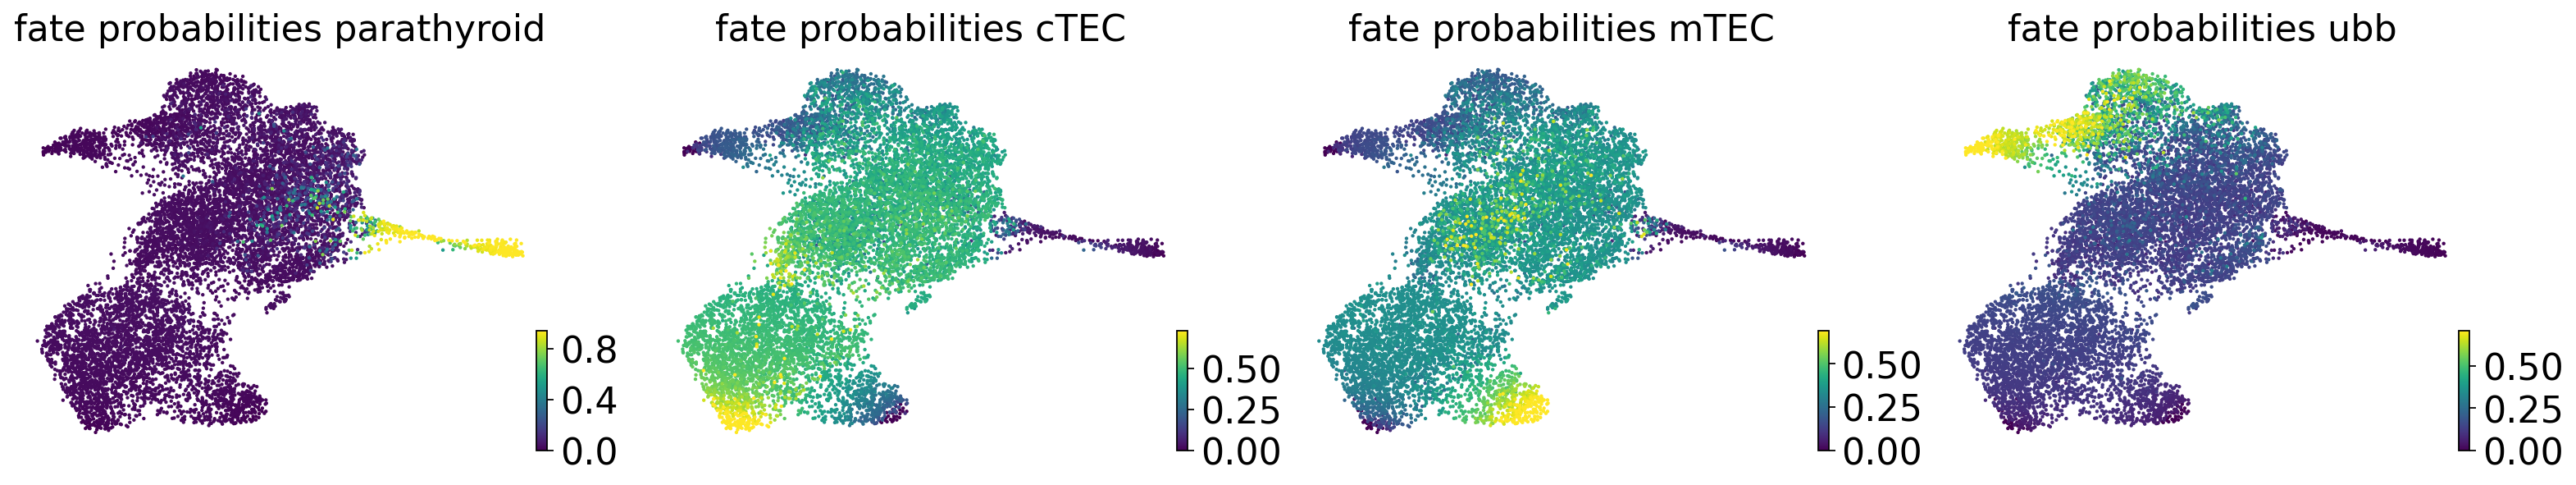

In [22]:
estimator.compute_fate_probabilities()
if running_in_notebook():
    estimator.plot_fate_probabilities(same_plot=False, basis="umap", perc=[0, 99], ncols=4)

if SAVE_FIGURES:
    for terminal_state in estimator.terminal_states.cat.categories:
        adata.obs[f"fate_prob_{terminal_state}"] = adata.obsm["lineages_fwd"][:, terminal_state].X.squeeze()
        fig, ax = plt.subplots(figsize=(6, 4))

        if running_in_notebook():
            scv.pl.scatter(
                adata,
                basis="umap",
                color=f"fate_prob_{terminal_state}",
                cmap="viridis",
                title="",
                colorbar=SHOW_COLORBAR,
                perc=[0, 99],
                ax=ax,
            )

            fig.savefig(
                FIG_DIR
                / "realtime_kernel"
                / "pharyngeal_endoderm"
                / f"fate_prob_{terminal_state}_clipped_subsetted_data.eps",
                format="eps",
                transparent=True,
                bbox_inches="tight",
            )

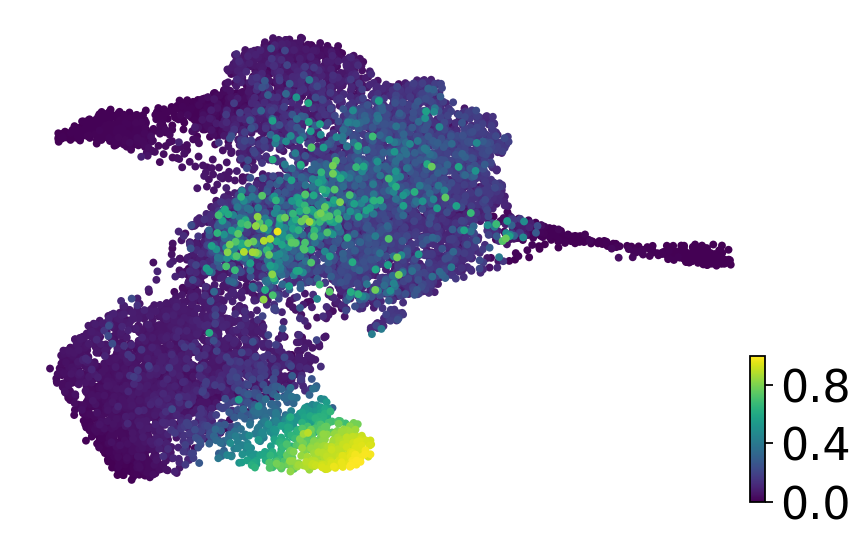

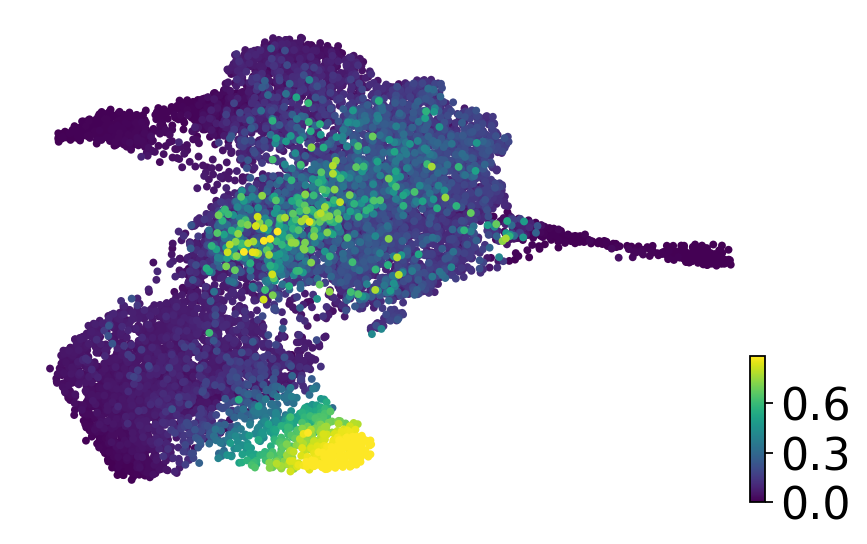

In [23]:
adata.obs["mTEC_abs_probs"] = adata.obsm["term_states_fwd_memberships"]["mTEC"].X.squeeze()
if running_in_notebook():
    fig, ax = plt.subplots(figsize=(6, 4))
    scv.pl.scatter(
        adata,
        basis="umap",
        c="mTEC_abs_probs",
        s=50,
        cmap="viridis",
        title="",
        legend_loc=None,
        colorbar=SHOW_COLORBAR,
        ax=ax,
    )
    if SAVE_FIGURES:
        fig.savefig(
            FIG_DIR / "realtime_kernel" / "pharyngeal_endoderm" / "mtec_fate_probs_subsetted_data.eps",
            format="eps",
            transparent=True,
            bbox_inches="tight",
        )

mTEC_abs_probs = adata.obsm["term_states_fwd_memberships"]["mTEC"].X.squeeze()
percentile = np.percentile(mTEC_abs_probs, 99)
mTEC_abs_probs = np.clip(mTEC_abs_probs, a_min=mTEC_abs_probs.min(), a_max=percentile)

adata.obs["mTEC_abs_probs"] = mTEC_abs_probs
if running_in_notebook():
    fig, ax = plt.subplots(figsize=(6, 4))
    scv.pl.scatter(
        adata,
        basis="umap",
        c="mTEC_abs_probs",
        s=50,
        cmap="viridis",
        title="",
        legend_loc=None,
        colorbar=SHOW_COLORBAR,
        ax=ax,
    )
    if SAVE_FIGURES:
        fig.savefig(
            FIG_DIR / "realtime_kernel" / "pharyngeal_endoderm" / "mtec_fate_probs_clipped_subsetted_data.eps",
            format="eps",
            transparent=True,
            bbox_inches="tight",
        )

### Driver analysis

In [24]:
# fmt: off
mtec_genes = [
    "Cldn3", "Cldn4", "Notch1", "Krt5", "H2-Aa", "H2-Ab1", "H2-Eb1",
    "Grhl3", "Grhl1", "Elf5", "Irf6", "Sox9", "Upk2", "Ovol1", "Hes1",
    "Rhov", "Pvrl4", "Klf5", "Egr1", "Sfn", "Perp", "Fxyd3", "Hspb1",
    "Krt5", "S100a11",
]
# fmt: on

In [25]:
drivers_mtec = estimator.compute_lineage_drivers(
    return_drivers=True, cluster_key="cluster_fine", lineages=["mTEC"], clusters=["2", "9"]
)

DEBUG: Computing correlations for lineages `['mTEC']` restricted to clusters `['2', '9']` in layer `X` with `use_raw=False`
Adding `adata.varm['terminal_lineage_drivers']`
       `.lineage_drivers`
    Finish (0:00:01)


In [26]:
gene_names = drivers_mtec.loc[
    ~(
        drivers_mtec.index.str.startswith(("mt.", "Rpl", "Rps", "^Hb[^(p)]"))
        | drivers_mtec.index.isin(S_GENES + G2M_GENES)
    ),
    :,
].index
cr_ranking = pd.DataFrame(
    drivers_mtec.loc[gene_names, "mTEC_corr"],
)
cr_ranking["ranking"] = np.arange(len(gene_names))
cr_ranking.to_csv(DATA_DIR / "pharyngeal_endoderm" / "results" / "driver_genes_ranking_cr.csv")

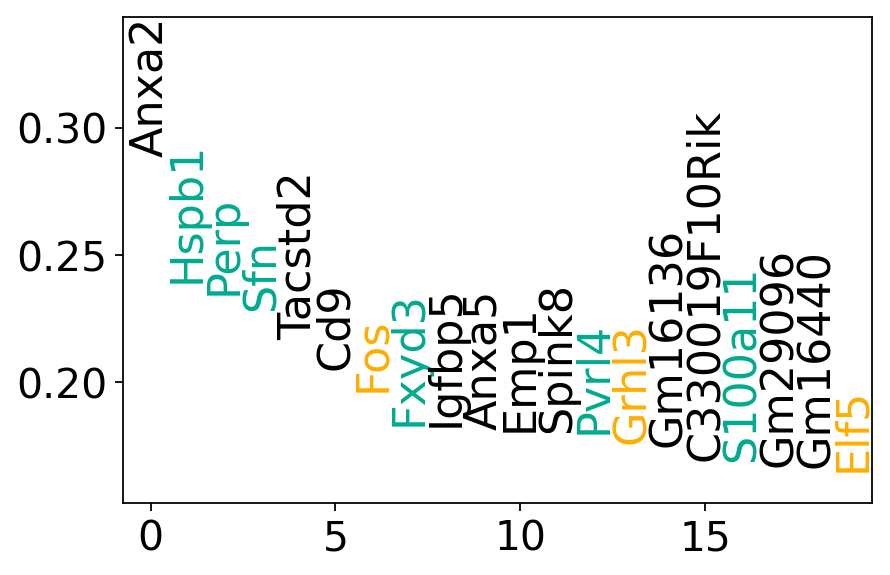

In [27]:
df = cr_ranking.iloc[:20, :]

if running_in_notebook():
    fig, ax = plt.subplots(figsize=(6, 4))
    y_min = np.min(df["mTEC_corr"])
    y_max = np.max(df["mTEC_corr"])

    y_min -= 0.1 * (y_max - y_min)
    y_max += 0.4 * (y_max - y_min)
    ax.set_ylim(y_min, y_max)

    ax.set_xlim(-0.75, 19.5)

    for gene in df.index:
        if gene in mouse_tfs:
            color = "#FEAE00"
        elif gene in mtec_genes:
            color = "#00AB8E"
        else:
            color = "#000000"
        ax.text(
            df.loc[gene, "ranking"],
            df.loc[gene, "mTEC_corr"],
            gene,
            rotation="vertical",
            verticalalignment="bottom",
            horizontalalignment="center",
            fontsize=20,
            color=color,
        )

    if SAVE_FIGURES:
        fig.savefig(
            FIG_DIR / "realtime_kernel" / "pharyngeal_endoderm" / "genes_ranked_by_correlation.eps",
            format="eps",
            transparent=True,
            bbox_inches="tight",
        )

### Classical DE testing

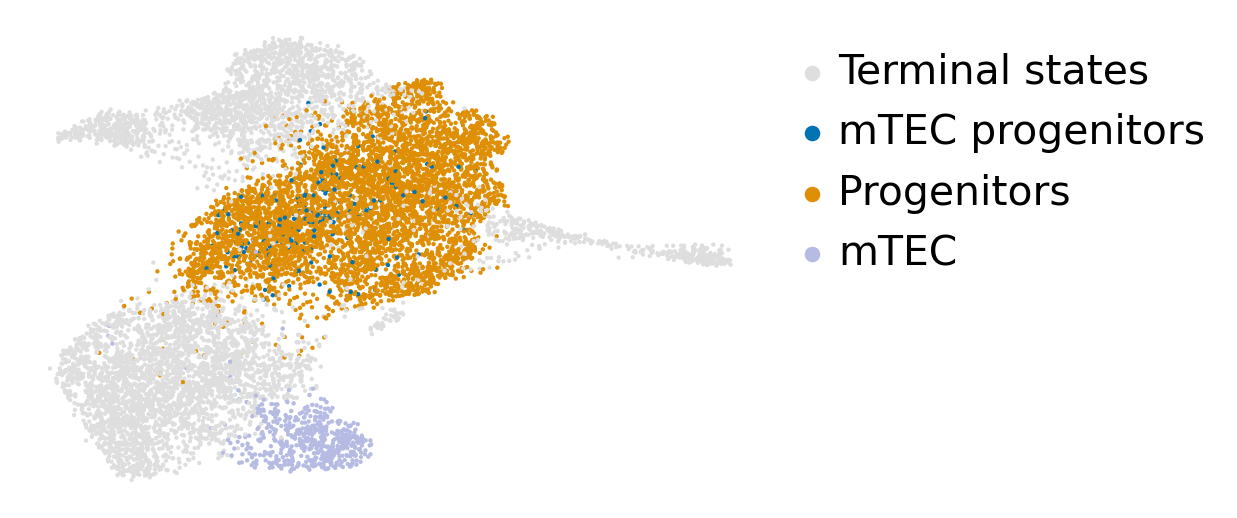

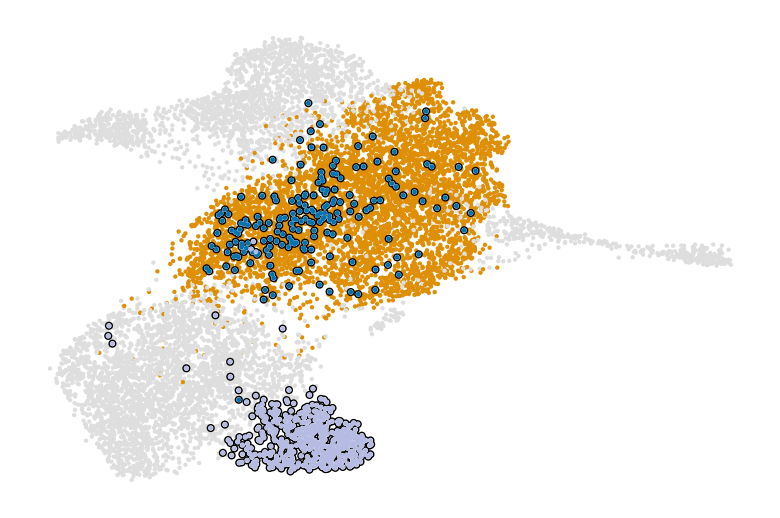

In [28]:
fate_prob_threshold = 0.5

adata.obs["mTEC_progenitors"] = False
adata.obs.loc[
    adata.obs["cluster_fine"].isin(["2", "9"]) & (adata.obs["mTEC_abs_probs"] > fate_prob_threshold), "mTEC_progenitors"
] = True

adata.obs["mTEC_progenitors_groups"] = "Terminal states"
adata.obs.loc[adata.obs["cluster_name"].isin(["mTEC"]), "mTEC_progenitors_groups"] = "mTEC"
adata.obs.loc[
    adata.obs["cluster_fine"].isin(["2", "9"]) & (adata.obs["mTEC_abs_probs"] <= fate_prob_threshold),
    "mTEC_progenitors_groups",
] = "Progenitors"
adata.obs.loc[
    adata.obs["cluster_fine"].isin(["2", "9"]) & (adata.obs["mTEC_abs_probs"] > fate_prob_threshold),
    "mTEC_progenitors_groups",
] = "mTEC progenitors"
adata.obs["mTEC_progenitors_groups"] = (
    adata.obs["mTEC_progenitors_groups"]
    .astype("category")
    .cat.reorder_categories(["Terminal states", "mTEC progenitors", "Progenitors", "mTEC"])
)
adata.uns["mTEC_progenitors_groups_colors"] = ["#dedede", "#0173b2", "#de8f05", "#b5bbe3"]

if running_in_notebook():
    fig, ax = plt.subplots(figsize=(6, 4))
    scv.pl.scatter(adata, basis="umap", c="mTEC_progenitors_groups", title="", ax=ax)
    fig, ax = plt.subplots(figsize=(6, 4))
    scv.pl.scatter(
        adata,
        basis="umap",
        c="mTEC_progenitors_groups",
        add_outline=["mTEC progenitors", "mTEC"],
        title="",
        legend_loc=False,
        ax=ax,
    )

    if SAVE_FIGURES:
        fig, ax = plt.subplots(figsize=(6, 4))
        scv.pl.scatter(
            adata,
            basis="umap",
            c="mTEC_progenitors_groups",
            add_outline=["mTEC progenitors", "mTEC"],
            title="",
            legend_loc=False,
            ax=ax,
        )
        fig.savefig(
            FIG_DIR / "realtime_kernel" / "pharyngeal_endoderm" / "umap_mtec_progenitors_subsetted_data.pdf",
            format="pdf",
            transparent=True,
            bbox_inches="tight",
            dpi=400,
        )

In [29]:
adata_progenitors = adata[
    adata.obs["mTEC_progenitors_groups"].isin(["Progenitors", "mTEC progenitors"]),
    ~(adata.var_names.str.startswith(("mt.", "Rpl", "Rps", "^Hb[^(p)]")) | adata.var_names.isin(S_GENES + G2M_GENES)),
].copy()

sc.tl.rank_genes_groups(
    adata_progenitors, groupby="mTEC_progenitors_groups", groups=["Progenitors", "mTEC progenitors"]
)

ranking genes
    finished (0:00:00)


In [30]:
gene_names = (
    pd.DataFrame(adata_progenitors.uns["rank_genes_groups"]["names"]).set_index("mTEC progenitors").index.tolist()
)
de_scores = (
    pd.DataFrame(adata_progenitors.uns["rank_genes_groups"]["scores"]).set_index("mTEC progenitors").index.tolist()
)
de_ranking = pd.DataFrame({"ranking": np.arange(len(de_scores)), "DE score": de_scores}, index=gene_names)
de_ranking.to_csv(DATA_DIR / "pharyngeal_endoderm" / "results" / "driver_genes_ranking_de.csv")

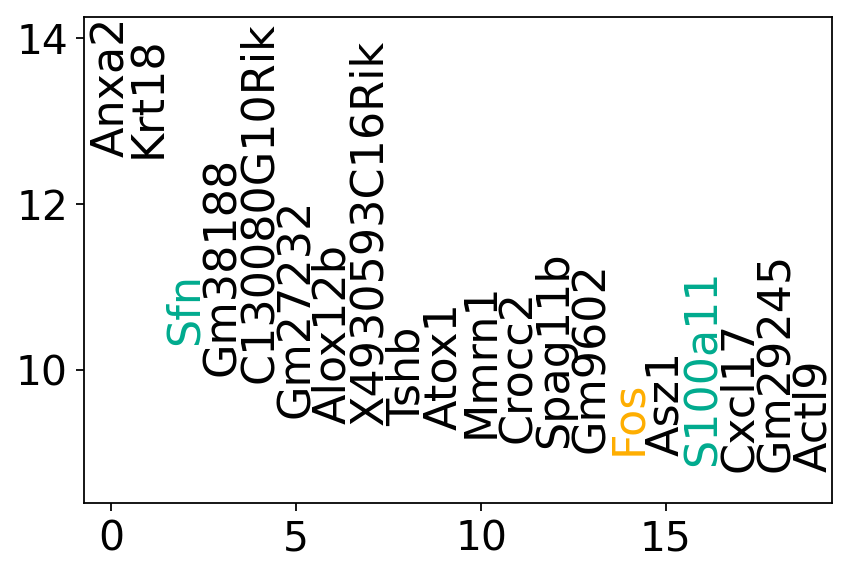

In [31]:
gene_names = (
    pd.DataFrame(adata_progenitors.uns["rank_genes_groups"]["names"]).set_index("mTEC progenitors").index.tolist()
)
de_scores = (
    pd.DataFrame(adata_progenitors.uns["rank_genes_groups"]["scores"]).set_index("mTEC progenitors").index.tolist()
)
df = de_ranking.iloc[:20, :]

if running_in_notebook():
    fig, ax = plt.subplots(figsize=(6, 4))
    y_min = np.min(df["DE score"])
    y_max = np.max(df["DE score"])

    y_min -= 0.1 * (y_max - y_min)
    y_max += 0.4 * (y_max - y_min)
    ax.set_ylim(y_min, y_max)

    ax.set_xlim(-0.75, 19.5)

    for gene in df.index:
        if gene in mouse_tfs:
            color = "#FEAE00"
        elif gene in mtec_genes:
            color = "#00AB8E"
        else:
            color = "#000000"
        ax.text(
            df.loc[gene, "ranking"],
            df.loc[gene, "DE score"],
            gene,
            rotation="vertical",
            verticalalignment="bottom",
            horizontalalignment="center",
            fontsize=20,
            color=color,
        )

    if SAVE_FIGURES:
        fig.savefig(
            FIG_DIR / "realtime_kernel" / "pharyngeal_endoderm" / "genes_ranked_by_de.eps",
            format="eps",
            transparent=True,
            bbox_inches="tight",
        )

In [32]:
_mtec_genes = list(set(mtec_genes).intersection(cr_ranking.index))

_perc = (cr_ranking.loc[_mtec_genes, "ranking"] <= de_ranking.loc[_mtec_genes, "ranking"]).mean() * 100
print(f"Percentage of genes that CR ranks higher or equal than classical DE: {_perc:.2f}%")

_perc = (cr_ranking.loc[_mtec_genes, "ranking"] < de_ranking.loc[_mtec_genes, "ranking"]).mean() * 100
print(f"Percentage of genes that CR ranks strictly higher than classical DE: {_perc:.2f}%")

Percentage of genes that CR ranks higher or equal than classical DE: 71.43%
Percentage of genes that CR ranks strictly higher than classical DE: 66.67%
